# Importing *Libraries*

In [ ]:
# imports for general libraries for plotting and more
import numpy as np
import os, time, zipfile, cv2, itertools
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('agg')
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split

# keras imports for the dataset and the networks
import tensorflow as tf
import tensorflow.keras as keras
from keras import models, layers, datasets, optimizers, regularizers, applications
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading Data

Mounted Google Drive and defining the common path for the folders dedicated to the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

origineColab = '/content/drive/My Drive/Colab Notebooks/ProgettoNN'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extracting the dataset zip 

In [ ]:
# Import and set dataset in COLAB:
local_zip = origineColab+'/dataset/DatasetProgettoNN.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

# Directory del dataset:
base_dir = '/content/DatasetProgettoNN'
train_dir = base_dir+'/train'
test_dir = base_dir+'/test'

Here the user can decide on some features of the network

In [ ]:
# 1. augmentation on the train and / or test dataset
# If you want the augmentation of the set of training set personalAg to 'YES', otherwise to 'NO'
# (N.B.: if you set it wrong, the parameter will be set to 'YES')
personalAg = 'YES'

# 2. choose the model: "VGG16" or "MobileNetv2"
choosenModel = "MobileNetv2"

# 3. choose early stopping "YES" or "NO"
earlyStopping = 'YES'

# 4. choose the layers not to train. It must be: 0, 4, 7, 11, 15, 19
doNotTrain = 0

# 5. choose the optimizier: "Adam" or "Adagrad"
chooseOptimizer = "Adagrad"

Definition of the macroparamaters, global variables and global path 

In [ ]:
img_width, img_height = 150, 150
maxEpochs = 75
split_for_validation = 0.15
nb_train_samples = 5120
nb_test_samples = 1280
batch_size = 64
formaInput = (img_width, img_height, 3)

# Checking the correct choice of the user
if personalAg!='YES': personalAg='NO'
if earlyStopping!='NO': earlyStopping='YES'
if doNotTrain not in [0, 4, 7, 11, 15, 19]: doNotTrain=0
if chooseOptimizer=="Adagrad":
    myOptimizer = "Adagrad"
else:
    myOptimizer = optimizers.Adam(lr=1e-6) 

# Genereting common and universal path:
nameModelTraining = choosenModel+'-personalAug'+personalAg+"-earlyStop"+earlyStopping
if choosenModel=="VGG16": nameModelTraining = nameModelTraining+"-doNotTrain"+str(doNotTrain)
if chooseOptimizer=="Adagrad": nameModelTraining = nameModelTraining+"-Adagrad"
directoryBase = origineColab+"/"+nameModelTraining
if not(os.path.exists(directoryBase)):
    os.makedirs(directoryBase)
    os.makedirs(directoryBase+"/results")
    os.makedirs(directoryBase+"/models")
    os.makedirs(directoryBase+"/resIm")
pathSaveModel       = directoryBase+'/results/'+nameModelTraining+'.h5'
pathPrintModel      = directoryBase+'/models/modello-'+nameModelTraining+'.png'
pathPrintHistogram  = directoryBase+'/models/istogramma-'+nameModelTraining+'.png'
pathPrintTraining   = directoryBase+'/resIm/stampeAdd-'+nameModelTraining+".png"
pathCM              = directoryBase+'/resIm/CM-'+nameModelTraining+'.png'

# Setting the Augmentation:
# Default:
personal_shear_range          = 0.0
personal_zoom_range           = 0.0
personal_width_shift_range    = 0.0
personal_horizontal_flip_mode = 0.0
personal_height_shift_range   = 0.0
personal_fill_mode            = "constant" # fills outlines when the image is augmented with the closest
# Augmentation activation if required
if personalAg == 'YES':
    personal_shear_range          = 0.06 # Angular distortion
    personal_zoom_range           = 0.06 # Zoom in the images
    personal_horizontal_flip_mode = 0.06 # horizontal flip of the images
    personal_width_shift_range    = 0.06 # horizontal movement of the photo to analyze it even when cropped
    personal_height_shift_range   = 0.06 # vertical movement of the photo to analyze it even when cropped


# Setting the EarlyStopping:
if earlyStopping == 'YES':
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0,
        verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callback = [ TensorBoard(update_freq=521),
                    EarlyStopping(monitor='val_accuracy', patience=2),
                    ModelCheckpoint(pathSaveModel, save_best_only=True), ]
else:
    callback = None

print("Name of the Training Model:")
print(nameModelTraining)

Name of the Training Model:
MobileNetv2-personalAugYES-earlyStopYES-Adagrad


The next cell is important to having an orderly reading of folders so you get the correct names

In [ ]:
# Forces folder sorting if they have names of different lengths
def classificator (directory):
    childDirectories = next(os.walk(directory))[1]
    for x in range(len(childDirectories)):
        childDirectories[x]=int(childDirectories[x])
    childDirectories.sort()
    for x in range(len(childDirectories)):
        childDirectories[x]=str(childDirectories[x])
    return childDirectories

Defining the names of the associated classes

In [ ]:
# Import the names of classes and categories
listNameFolders = []
listNameFolders = os.listdir(base_dir)
if '.DS_Store' in listNameFolders:
  listNameFolders.remove('.DS_Store')

listNamesClasses = []
for c in listNameFolders:
  cartelle = os.listdir(base_dir+"/"+c)
  for elem in cartelle:
    if elem==".DS_Store" or elem in listNamesClasses: continue
    listNamesClasses.append(elem)
#print(listNameFolders)
print(listNamesClasses)

['alzheimers', 'nonalzheimers']


# Creating the Model

In [ ]:
def make_train_generator():
    # Augmentation configuration for the dataset
    X_datagen = ImageDataGenerator(
        rescale=1. / 255)
    X_generator = X_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        color_mode="rgb",
        batch_size=nb_train_samples,
        class_mode='binary',
        subset='training',
        shuffle=True)
    return X_generator

def make_test_generator():
    # Augmentation configuration for the dataset
    X_datagen = ImageDataGenerator(
        rescale=1. / 255)
    X_generator = X_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        color_mode="rgb",
        batch_size=nb_test_samples,
        class_mode='binary',
        subset='training',
        shuffle=True)
    return X_generator

def make_AUGMENTATION_train_generator():
  # Augmentation configuration for the dataset
  X_datagen = ImageDataGenerator(
      rescale=1. / 255,
      height_shift_range  = personal_height_shift_range,
      shear_range         = personal_shear_range,
      zoom_range          = personal_zoom_range,
      fill_mode           = personal_fill_mode,
      width_shift_range   = personal_width_shift_range,
      horizontal_flip     = personal_horizontal_flip_mode
      )
  X_orig_generator = X_datagen.flow_from_directory(
      train_dir,
      target_size=(img_width, img_height),
      color_mode="rgb",
      batch_size=nb_train_samples,
      class_mode='binary',
      subset='training',
      shuffle=True)
  return X_orig_generator

Importing the dataset and defining training, validation and test sets

In [ ]:
# importing the dataset using tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(make_train_generator, (tf.float32, tf.float32))
test_dataset = tf.data.Dataset.from_generator(make_test_generator, (tf.float32, tf.float32))

# obtaining images and labels from datasets created with generators
for images, labels in train_dataset.take(1):
    X_train = images.numpy()
    Y_train = labels.numpy()

for images, labels in test_dataset.take(1):
    X_test = images.numpy()
    Y_test = labels.numpy()

# If there is augmentation, I call a generator again, but this time it contains instructions for augmentation, and then I merge the set without augmentation with the one that has it.
if personalAg=="YES":
    train_AUGMENTATION_dataset = tf.data.Dataset.from_generator(make_AUGMENTATION_train_generator, (tf.float32, tf.float32))
    for images, labels in train_AUGMENTATION_dataset.take(1):
        X_train_orig = images.numpy()
        Y_train_orig = labels.numpy()
    X_train = np.concatenate((X_train, X_train_orig), axis=0)
    Y_train = np.concatenate((Y_train, Y_train_orig), axis=0)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=split_for_validation, random_state=1)

print("Samples of training set: "+str(len(X_train)))
print("Samples of validation set: "+str(len(X_valid)))
print("Samples of test set: "+str(len(X_test)))

Found 5120 images belonging to 2 classes.
Found 1280 images belonging to 2 classes.
Found 5120 images belonging to 2 classes.
Samples of training set: 8704
Samples of validation set: 1536
Samples of test set: 1280


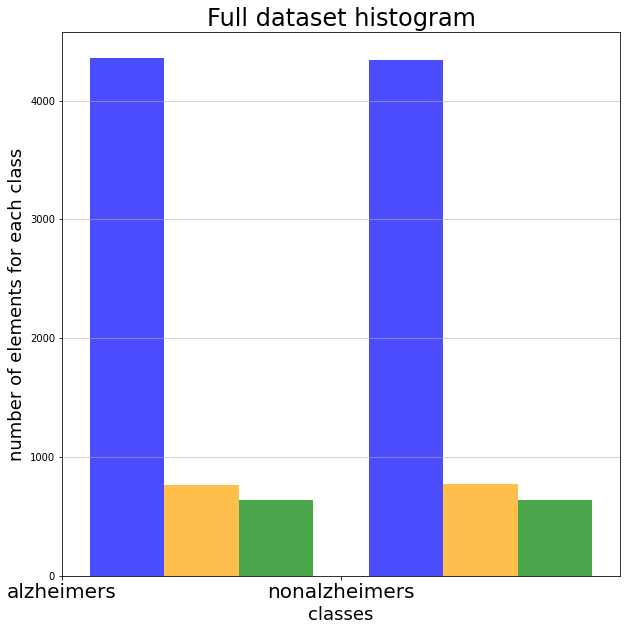

In [ ]:
# HISTOGRAM REPRESENTATION
# Generate names of the x axis
valAsseX = listNamesClasses

# Creating alignment for the x axis results
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plt.figure(num=None, figsize=(10, 10))
bins = range(3)
plt.hist([Y_train, Y_valid, Y_test], bins=bins, color=['blue', 'orange', 'green'], alpha=0.7)
bins_labels(bins, fontsize=20)
plt.xlabel("classes", fontsize=18)
plt.ylabel("number of elements for each class", fontsize=18)
plt.xticks(np.arange(len(valAsseX)),valAsseX)
plt.title('Full dataset histogram', fontsize=24)
plt.grid(axis='y', alpha=0.7)
plt.savefig(pathPrintHistogram)
plt.show()

# Model

Define the model based on the user's choices

In [ ]:
print('Dimension of the training set:',X_train.shape)
print('Dimension of the validation set:',X_valid.shape)
print('Dimension of the test set:',X_test.shape)

# MobileNetV2 has predetermined dimensions for the input images, so a resize with interpolation is required
if(choosenModel=="MobileNetv2"):
    def resize_dataset(dataset):
        dataset_resized = []
        for i in range(len(dataset)):
            dataset_resized.append(cv2.resize(dataset[i], dsize=(128, 128), interpolation=cv2.INTER_CUBIC))
        dataset_resized = np.array(dataset_resized)
        return dataset_resized

    print("\nStarting the reshape for the training set.")
    X_train = resize_dataset(X_train)
    print("Finished with the training set. Starting the reshape for the validation set.")
    X_valid = resize_dataset(X_valid)
    print("Finished with the validation set. Starting the reshape for the test set.")
    X_test = resize_dataset(X_test)
    print("Finished with the test set.\n")
    formaInput = (128, 128, 3)

    print('Dimension of the reshaped training set:',X_train.shape)
    print('Dimension of the reshaped validation set:',X_valid.shape)
    print('Dimension of the reshaped test set:',X_test.shape)

Dimension of the training set: (8704, 150, 150, 3)
Dimension of the validation set: (1536, 150, 150, 3)
Dimension of the test set: (1280, 150, 150, 3)

Starting the reshape for the training set.
Finished with the training set. Starting the reshape for the validation set.
Finished with the validation set. Starting the reshape for the test set.
Finished with the test set..

Dimension of the reshaped training set: (8704, 128, 128, 3)
Dimension of the reshaped validation set: (1536, 128, 128, 3)
Dimension of the reshaped test set: (1280, 128, 128, 3)


In [ ]:
if choosenModel=="VGG16":
    base_model = tf.keras.applications.VGG16(input_shape=formaInput, include_top=False, weights="imagenet")
    base_model.trainable = True
    base_model.summary()
    for layer in base_model.layers[:doNotTrain]:
            layer.trainable = False
    # Adding custom Layers 
    def model_sequential():
        model = Sequential()
        model.add(base_model)
        model.add(Flatten(input_shape=base_model.output_shape[1:]))
        model.add(Dense(512, activation=tf.nn.leaky_relu))
        model.add(Dropout(0.4)) 
        model.add(Dense(256, activation=tf.nn.leaky_relu))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))
        return model
    personalModel = model_sequential()
    personalModel.summary()
    tf.keras.utils.plot_model(personalModel, to_file=pathPrintModel)
    personalModel.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=myOptimizer, metrics=['accuracy'])
elif choosenModel=="MobileNetv2":
    base_model = tf.keras.applications.MobileNetV2(input_shape=formaInput, include_top=False, weights="imagenet")
    base_model.trainable = True
    # Adding custom Layers 
    def model_sequential():
        model = Sequential()
        model.add(base_model)
        model.add(Flatten(input_shape=base_model.output_shape[1:]))
        model.add(Dense(1024, activation=tf.nn.leaky_relu))
        model.add(Dropout(0.4))
        model.add(Dense(256, activation=tf.nn.leaky_relu))
        model.add(Dense(64, activation=tf.nn.leaky_relu))
        model.add(Dense(1, activation='sigmoid'))
        return model 
    personalModel = model_sequential()
    personalModel.summary()
    tf.keras.utils.plot_model(personalModel, to_file=pathPrintModel)
    personalModel.compile(optimizer=myOptimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              20972544  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
___________________________________________________________

# Training the Network

Epoch 1/75
136/136 - 51s - loss: 0.6504 - accuracy: 0.6544 - val_loss: 0.9041 - val_accuracy: 0.5137
Epoch 2/75
136/136 - 44s - loss: 0.4873 - accuracy: 0.7593 - val_loss: 0.8540 - val_accuracy: 0.5410
Epoch 3/75
136/136 - 44s - loss: 0.3932 - accuracy: 0.8197 - val_loss: 0.7792 - val_accuracy: 0.5892
Epoch 4/75
136/136 - 43s - loss: 0.2934 - accuracy: 0.8745 - val_loss: 0.7336 - val_accuracy: 0.6094
Epoch 5/75
136/136 - 43s - loss: 0.2012 - accuracy: 0.9234 - val_loss: 0.6947 - val_accuracy: 0.6647
Epoch 6/75
136/136 - 44s - loss: 0.1437 - accuracy: 0.9458 - val_loss: 0.6843 - val_accuracy: 0.6888
Epoch 7/75
136/136 - 44s - loss: 0.0851 - accuracy: 0.9708 - val_loss: 0.8739 - val_accuracy: 0.6576
Epoch 8/75
136/136 - 43s - loss: 0.0623 - accuracy: 0.9801 - val_loss: 0.8926 - val_accuracy: 0.6628


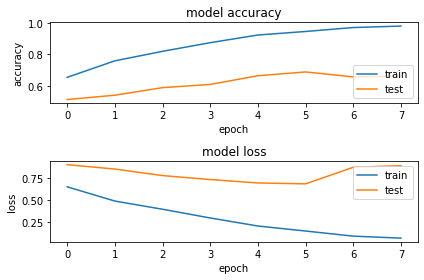

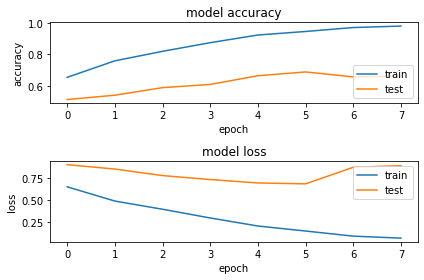

In [ ]:
# Starting the stopwatch to find out how long the training lasts
t0 = time.time()

# Start Training
history = personalModel.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=maxEpochs,
                    verbose=2,
                    validation_data=(X_valid, Y_valid),
                    callbacks=callback)


# Printing the progress of the train
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()
plt.savefig(pathPrintTraining)

fig

Computing the time of training


In [ ]:
t1 = time.time()
hours, rem = divmod(t1-t0, 3600)
minutes, seconds = divmod(rem, 60)

print("Training time in hours-minutes-seconds-waste. Remaining:")
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Training time in hours-minutes-seconds-waste. Remaining:
00:06:21.73


# Evaluation

Loading the model from saving and calculating accuracy and loss

In [ ]:
personalModel = load_model(pathSaveModel, custom_objects={'leaky_relu': tf.nn.leaky_relu})

loss_and_metrics = personalModel.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

40/40 - 3s - loss: 0.6605 - accuracy: 0.6836
Test Loss 0.6605170965194702
Test Accuracy 0.68359375


Printing the Classification Report

In [ ]:
y_pred = personalModel.predict(X_test).round()
print(classification_report(Y_test, y_pred, labels=None, target_names=listNamesClasses, digits=2))

               precision    recall  f1-score   support

   alzheimers       0.71      0.62      0.66       640
nonalzheimers       0.66      0.75      0.70       640

     accuracy                           0.68      1280
    macro avg       0.69      0.68      0.68      1280
 weighted avg       0.69      0.68      0.68      1280



Defining and Plotting the Confusion Matrix

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_pred)
np.set_printoptions(precision=2)
print(cnf_matrix)

[[398 242]
 [163 477]]


Confusion matrix without normalization


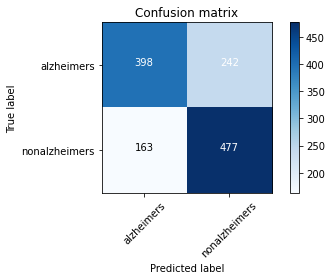

In [ ]:
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(pathCM)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=listNamesClasses, title='Confusion matrix')